Dipolar emitter coupled to gold split-ring resonator
=================================

In this example, we try to obtain the results reported by Hancu *et. al* [1]: The scattering from a dipolar emitter, coupled to a gold split-ring resonator, becomes highly directional.


[1] Hancu, I. M. et al. *Multipolar Interference for Directed Light Emission*. **Nano Lett.** 14, 166–171 (2014) (http://dx.doi.org/10.1021/nl403681g)

In [1]:
from pyGDM2 import structures
from pyGDM2 import materials
from pyGDM2 import fields

from pyGDM2 import core
from pyGDM2 import linear
from pyGDM2 import tools
from pyGDM2 import visu

import numpy as np
import matplotlib.pyplot as plt

Simulation setup
----------------------

Again, we setup the simulation. This time we **will not** use a plane wave, but rather a *dipolar emitter* as light source.
The dipole will be placed in the center of the split-ring resonator and we will compare two orientations of the dipole (along *X* and along *Y*).

In [2]:
## --- structure and envorinment
mesh = 'cube'
step = 30.0
geometry = structures.rect_split_ring(step, L1=12,L2=16,H=3,W=3, G=False, mesh=mesh)
material = materials.gold()

n1, n2 = 1.0, 1.0  # constant environment

geometry = structures.center_struct(geometry)
struct = structures.struct(step, geometry, material, n1,n2, structures.get_normalization(mesh))


## --- incident field: dipolar emitter
field_generator = fields.dipole_electric   # light-source: dipolar emitter
kwargs = dict(x0=0, y0=0, z0=1.5*step, 
              mx=[1,0], my=[0,1], mz=0)
wavelengths = [1000.]
efield = fields.efield(field_generator, wavelengths=wavelengths, kwargs=kwargs)


## --- Simulation object
sim = core.simulation(struct, efield)

## --- print a summary
tools.print_sim_info(sim, verbose=1)

 =============== GDM Simulation Information ===============
precision: <type 'numpy.float32'> / <type 'numpy.complex64'>


 ------ nano-object -------
   Homogeneous object. 
   material:             "Gold, Johnson/Christy"
   mesh type:            cubic
   nominal stepsize:     30.0nm
   nr. of meshpoints:    342

 ----- incident field -----
   field generator: "dipole_electric"
   1 wavelengths between 1000.0 and 1000.0nm
      - 0: 1000.0nm
   4 incident field configurations per wavelength
      - 0: 'my': 0, 'y0': 0, 'x0': 0, 'z0': 45.0, 'mx': 1, 'mz': 0
      - 1: 'my': 1, 'y0': 0, 'x0': 0, 'z0': 45.0, 'mx': 1, 'mz': 0
      - 2: 'my': 0, 'y0': 0, 'x0': 0, 'z0': 45.0, 'mx': 0, 'mz': 0
      - 3: 'my': 1, 'y0': 0, 'x0': 0, 'z0': 45.0, 'mx': 0, 'mz': 0

 ------ environment -------
   n3 = (1+0j)  <-- top
   n2 = (1+0j)  <-- structure zone (height "spacing" = 5000.0nm)
   n1 = (1+0j)  <-- substrate

 ===== *core.scatter* ======
   NO self-consistent fields



**Note:** pyGDM automatically generates all possible permutations of field-configurations: 
So we not only get simulations for the dipole along *X* (field-index *0*) and along *Y* (field-index *3*), but also a dipole vector *(1,1,0)* and a dipole vector *(0,0,0)* (the latter doesn't seem to make too much sense anyways). This is however merely a question of a bit more memory used, since the concept of the generalized propagator allows a very efficient calculation of these field-configurations. If you would like to only simulate the two configurations that we actually need (indices *0* and *3*), you could of course do this by creating two separate simulations.
**Note however**, that in this case, the generalized propagator would be calculated twice, which most certainly would take much more computation time than calculating the two field-configurations that we don't actually need.

Let's

Run the simulation
---------------------------------------

After the main simulation (*core.scatter*), we will calculate the spatial distribution of the farfield intensity in the upper hemisphere (--> backscattering) for the *X* and the *Y* dipole using *linear.farfield*.

In [3]:
E = core.scatter(sim)

## --- farfield pattern ("backfocal plane image")
Nteta=40; Nphi=2*72

teta, phi, I_sc_0, I_tot_0, I0_0 = linear.farfield(
                                sim, field_index=0,   # index 0: dipole || X 
                                tetamin=0, tetamax=np.pi/2., 
                                Nteta=Nteta, Nphi=Nphi)
teta, phi, I_sc_90, I_tot_90, I0_90 = linear.farfield(
                                sim, field_index=3,   # index 3: dipole || Y
                                tetamin=0, tetamax=np.pi/2., 
                                Nteta=Nteta, Nphi=Nphi)

timing 1000.00nm:     187.3 ms


Plot the farfield intensity distribution
---------------------------------------------

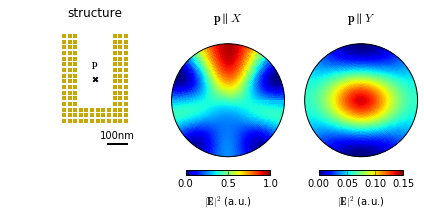

In [4]:
scale_I = 1E16

def conf_polar():
    plt.ylim([0, 90])
    plt.gca().set_xticklabels([])
    plt.gca().set_yticklabels([])


plt.figure()

## --- structure geometry
plt.subplot(131, aspect='equal')
plt.title("structure")
plt.axis('off')

## structure
visu.structure(geometry, color='#c7a800', scale=0.45, show=False)

## dipole position
plt.text(0, 40, r"$\mathbf{p}$", ha='center', va='bottom')
plt.scatter([0], [0], marker='x', linewidth=2, s=20, color='k')

## scale bar
plt.text(120,-330, "100nm", ha='center', va='bottom')
plt.plot([70,170] , [-350,-350], lw=2, color='k', clip_on=False)

geo_dim = 300
plt.xlim([-geo_dim, geo_dim])
plt.ylim([-geo_dim, geo_dim])


## --- pattern for dipole along X
plt.subplot(132, polar=True)
plt.title("$\mathbf{p} \parallel X$", x=0.5, y=1.15)
visu.farfield_pattern_2D(teta, phi, I_sc_0*scale_I, degrees=True, show=False)
conf_polar()

plt.colorbar(orientation='horizontal', label=r'$|\mathbf{E}|^2$ (a.u.)', 
             shrink=0.75, pad=0.05, aspect=15, ticks=[0, 0.5, 1.0])
plt.clim([0, 1])


## --- pattern for dipole along Y
plt.subplot(133, polar=True)
plt.title("$\mathbf{p} \parallel Y$", x=0.5, y=1.15)
im = visu.farfield_pattern_2D(teta, phi, I_sc_90*scale_I, degrees=True, show=False)
conf_polar()

plt.colorbar(orientation='horizontal', label=r'$|\mathbf{E}|^2$ (a.u.)', 
             shrink=0.75, pad=0.05, aspect=15, ticks=[0, 0.05, 0.10, 0.15])
plt.clim([0, 0.15])


plt.tight_layout()
plt.show()

This actually wraps up the message of reference [1] (see above): A dipole inside the split-ring oriented parallel to the "open" side will scatter towards the gap of the split ring, while scattering from a dipole pointing towards the gap won't be affected in this way.